## Лабораторная работа № 7
## Сикорский М8О-408Б-20

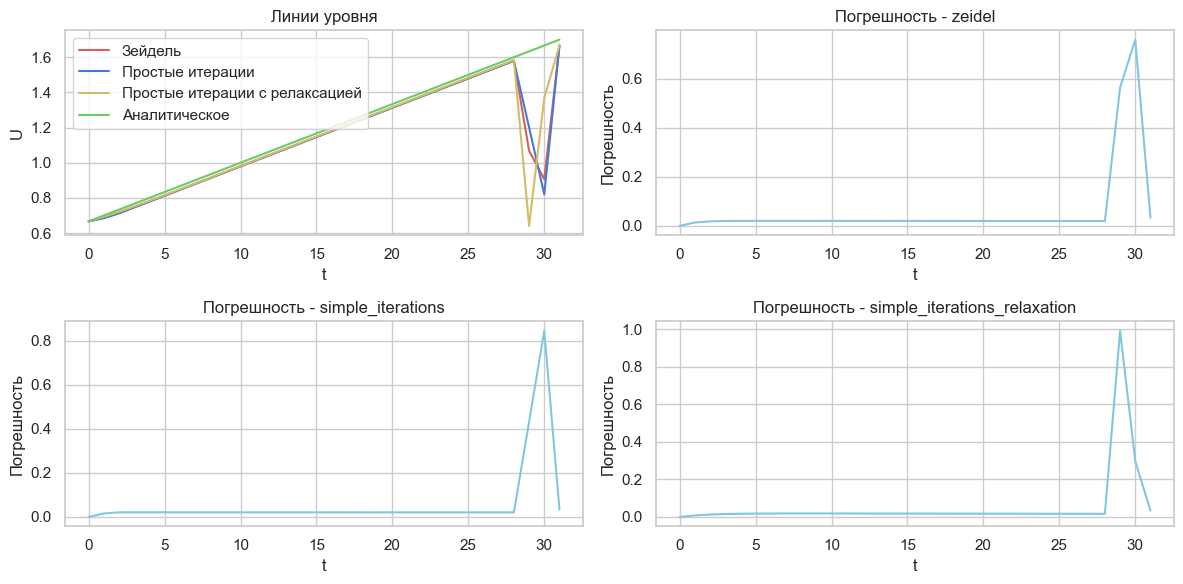

In [43]:
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import numpy as np

class Solver:
    def __init__(self, args, nx, ny):
        self.data = Parameters(args)
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        self.x = np.arange(0, self.data.lx + self.hx, self.hx)
        self.y = np.arange(0, self.data.ly + self.hy, self.hy)

        self.u = self.initialize_u()
        for i in range(1, nx):
            for j in range(1, ny):
                self.u[i][j] = (
                    self.u[0][j] + (self.x[i] - self.x[0]) * (self.u[-1][j] - self.u[0][j]) / (self.x[-1] - self.x[0])
                )
        self.iteration = 0
        self.eps = 1e-6

    def initialize_u(self):
        u = np.zeros((len(self.x), len(self.y)))
        for i in range(len(self.x)):
            u[i][0] = self.data.phi3(self.x[i]) / self.data.gamma2
            u[i][-1] = self.data.phi4(self.x[i]) / self.data.delta2
        for j in range(len(self.y)):
            u[0][j] = self.data.phi1(self.y[j]) / self.data.alpha2
            u[-1][j] = self.data.phi2(self.y[j]) / self.data.beta2
        return u

    def analytic_solve(self, nx, ny):
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        x = np.arange(0, self.data.lx + self.hx, self.hx)
        y = np.arange(0, self.data.ly + self.hy, self.hy)
        u = [[self.data.solution(xi, yi) for xi in x] for yi in y]
        return u

    def simple_iteration_method_solver(self, nx, ny):
        cur_eps = 1e5
        while self.iteration < 100:
            L = copy.deepcopy(self.u)
            u = self.initialize_u()
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    u[i][j] = (
                        (self.hx * self.hx * self.data.f(self.x[i], self.y[j]) -
                         (L[i + 1][j] + L[i - 1][j]) - self.data.d * self.hx * self.hx *
                         (L[i][j + 1] + L[i][j - 1]) / (self.hy * self.hy) - self.data.a * self.hx * 0.5 *
                         (L[i + 1][j] - L[i - 1][j]) - self.data.b * self.hx * self.hx *
                         (L[i][j + 1] - L[i][j - 1]) / (2 * self.hy)) /
                        (self.data.c * self.hx * self.hx - 2 * (self.hy * self.hy + self.data.d * self.hx * self.hx) /
                         (self.hy * self.hy))
                    )
            last_eps = cur_eps
            cur_eps = calculate_max_difference(L, u, nx, ny)
            if cur_eps <= self.eps or last_eps < cur_eps:
                break
            self.iteration += 1
        return u, self.iteration

    def zeidel_method_solver(self, nx, ny):
        cur_eps = 1e5
        while self.iteration < 100:
            L = copy.deepcopy(self.u)
            u = self.initialize_u()
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    u[i][j] = (
                        (self.hx ** 2 * self.data.f(self.x[i], self.y[j]) -
                         (L[i + 1][j] + u[i - 1][j]) - self.data.d * self.hx ** 2 *
                         (L[i][j + 1] + u[i][j - 1]) / (self.hy ** 2) - self.data.a * self.hx * 0.5 *
                         (L[i + 1][j] - u[i - 1][j]) - self.data.b * self.hx ** 2 *
                         (L[i][j + 1] - u[i][j - 1]) / (2 * self.hy)) /
                        (self.data.c * self.hx ** 2 - 2 * (self.hy ** 2 + self.data.d * self.hx ** 2) /
                         (self.hy ** 2))
                    )
            last_eps = cur_eps
            cur_eps = calculate_max_difference(L, u, nx, ny)
            if cur_eps <= self.eps or last_eps < cur_eps:
                break
            self.iteration += 1
        return u, self.iteration

    def simple_iteration_method_relaxed_solver(self, nx, ny):
        cur_eps = 1e5
        while self.iteration < 100:
            L = copy.deepcopy(self.u)
            u = self.initialize_u()
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    u[i][j] = (
                        ((self.hx ** 2) * self.data.f(self.x[i], self.y[j]) -
                         (L[i + 1][j] + u[i - 1][j]) - self.data.d * (self.hx ** 2) *
                         (L[i][j + 1] + u[i][j - 1]) / (self.hy ** 2) - self.data.a * self.hx * 0.5 *
                         (L[i + 1][j] - u[i - 1][j]) - self.data.b * (self.hx ** 2) *
                         (L[i][j + 1] - u[i][j - 1]) /
                         (2 * self.hy)) /
                        (self.data.c * (self.hx ** 2) - 2 * (self.hy ** 2 + self.data.d * (self.hx ** 2)) /
                         (self.hy ** 2))
                    ) * self.data.w + (1 - self.data.w) * L[i][j]
            last_eps = cur_eps
            cur_eps = calculate_max_difference(L, u, nx, ny)
            if cur_eps <= self.eps or last_eps < cur_eps:
                break
            self.iteration += 1
        return u, self.iteration


class Parameters:
    def __init__(self, args):
        self.a = args['a']
        self.b = args['b']
        self.c = args['c']
        self.d = args['d']
        self.lx = args['lx']
        self.ly = args['ly']
        self.w = args['w']
        self.f = args['f']
        self.alpha1 = args['alpha1']
        self.alpha2 = args['alpha2']
        self.beta1 = args['beta1']
        self.beta2 = args['beta2']
        self.gamma1 = args['gamma1']
        self.gamma2 = args['gamma2']
        self.delta1 = args['delta1']
        self.delta2 = args['delta2']
        self.phi1 = args['phi1']
        self.phi2 = args['phi2']
        self.phi3 = args['phi3']
        self.phi4 = args['phi4']
        self.solution = args['solution']

def calculate_max_difference(L, u, rows, cols):
    max_difference = 0
    for i in range(rows):
        for j in range(cols):
            max_difference = max(max_difference, abs(L[i][j] - u[i][j]))
    return max_difference


def compare_error(a, b):
    err = 0
    lst = [abs(i - j) for i, j in zip(a, b)]
    for each in lst:
        err = max(err, each)
    return err


def plot_results(dict_, time=0):
    sns.set(style="whitegrid", palette="muted", color_codes=True)
    plt.figure(figsize=(12, 6))

    # Plotting level lines
    plt.subplot(2, 2, 1)
    plt.title('Линии уровня')
    plt.plot(dict_['zeidel'][time], color='r', label='Зейдель')
    plt.plot(dict_['simple_iterations'][time], color='b', label='Простые итерации')
    plt.plot(dict_['simple_iterations_relaxation'][time], color='y', label='Простые итерации с релаксацией')
    plt.plot(dict_['analytics'][time], color='g', label='Аналитическое')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('t')

    # Plotting error for each method
    methods = ['zeidel', 'simple_iterations', 'simple_iterations_relaxation']
    for i, method in enumerate(methods, start=2):
        plt.subplot(2, 2, i)
        plt.title(f'Погрешность - {method}')
        plt.plot(abs(dict_[method][time] - dict_['analytics'][time]), color='c')
        plt.ylabel('Погрешность')
        plt.xlabel('t')

    plt.tight_layout()
    plt.show()


data = {'nx': 30, 'ny': 30}
nx, ny = int(data['nx']), int(data['ny'])
args = {
    'a': 0,
    'b': 0,
    'c': 2,
    'd': 1,
    'lx': 1,
    'ly': 1,
    'w': 1.5,
    'f': lambda x, y: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 0,
    'beta2': 1,
    'gamma1': 0,
    'gamma2': 1,
    'delta1': 0,
    'delta2': 1,
    'phi1': lambda y: y,
    'phi2': lambda y: 1 + y,
    'phi3': lambda x: x,
    'phi4': lambda x: 1 + x,
    'solution': lambda x, y: x + y
}

analytics = Solver(args, nx, ny)
simple_iterations = Solver(args, nx, ny)
zeidel = Solver(args, nx, ny)
simple_iterations_relaxation = Solver(args, nx, ny)

methods_results_map = {
    'analytics': analytics.analytic_solve(nx, ny),
    'zeidel': zeidel.zeidel_method_solver(nx, ny)[0],
    'simple_iterations': simple_iterations.simple_iteration_method_solver(nx, ny)[0],
    'simple_iterations_relaxation': simple_iterations_relaxation.simple_iteration_method_relaxed_solver(nx, ny)[0]
}

plot_results(methods_results_map, 20)


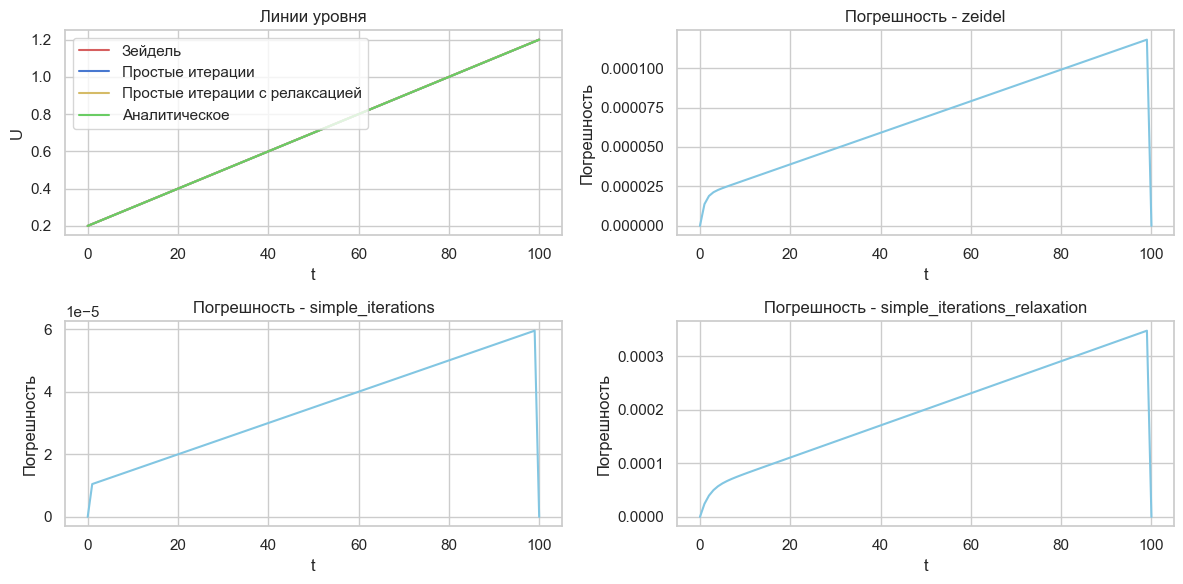

In [44]:
data = {'nx': 100, 'ny': 100}
nx, ny = int(data['nx']), int(data['ny'])
args = {
    'a': 0,
    'b': 0,
    'c': 2,
    'd': 1,
    'lx': 1,
    'ly': 1,
    'w': 1.5,
    'f': lambda x, y: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 0,
    'beta2': 1,
    'gamma1': 0,
    'gamma2': 1,
    'delta1': 0,
    'delta2': 1,
    'phi1': lambda y: y,
    'phi2': lambda y: 1 + y,
    'phi3': lambda x: x,
    'phi4': lambda x: 1 + x,
    'solution': lambda x, y: x + y
}

analytics = Solver(args, nx, ny)
simple_iterations = Solver(args, nx, ny)
zeidel = Solver(args, nx, ny)
simple_iterations_relaxation = Solver(args, nx, ny)

methods_results_map = {
    'analytics': analytics.analytic_solve(nx, ny),
    'zeidel': zeidel.zeidel_method_solver(nx, ny)[0],
    'simple_iterations': simple_iterations.simple_iteration_method_solver(nx, ny)[0],
    'simple_iterations_relaxation': simple_iterations_relaxation.simple_iteration_method_relaxed_solver(nx, ny)[0]
}

plot_results(methods_results_map, 20)